<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = "capstone_user_identification"

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' ВАШ КОД ЗДЕСЬ '''
    
    
    files_list = glob(os.path.join(path_to_csv_files, 'user*.csv'))

    sites = list()
    diffs = list()
    session_timespan = list()
    unique_sites = list()
    start_hour = list()
    day_of_week = list()
    y_users = list()
    with open(site_freq_path, 'rb') as file:
            sites_dict = pickle.load(file)


    for path in tqdm_notebook(files_list):

            # зчитування
            df = pd.read_csv(path)

            # обробка сайтів та заміна значень зі словника
            df['site'] = df['site'].apply(lambda i: sites_dict[i][0])
            df = df.to_numpy()
        

            # створення координат для нової матриці за введеними параметрами session_length та window_size
            coords = np.array([np.arange(i, i + session_length) for i in range(0, df.shape[0], window_size)])

            # додавання нулів
            zeroes = [0] * (coords.size - df.shape[0])
            zeroes = np.array(zeroes * 2).reshape((len(zeroes), 2))
            if zeroes.shape[0] > 0:
                df = np.concatenate((df, zeroes), axis = 0)

            # створення матриці за координатами
            diffs.append(np.apply_along_axis(np.vectorize(lambda i: df[i, 0]), 1, coords))
            sites.append(np.apply_along_axis(np.vectorize(lambda i: df[i, 1]), 1, coords))

            # додаємо до вектора годин та дня неділі сесії значення
            min_time_values = pd.to_datetime(diffs[-1][:, 0])
            start_hour += list(min_time_values.hour)
            day_of_week += list(min_time_values.dayofweek)

            # обробка часу
            t1 = diffs[-1][:, 1:].astype(np.datetime64)
            t2 = diffs[-1][:, :-1].astype(np.datetime64)
            diffs[-1] = (t1 - t2).astype(np.int64)
            diffs[-1][diffs[-1] < 0] = 0


            # додаємо до вектора часу сесії значення
            session_timespan += list(np.apply_along_axis(np.sum, 1, diffs[-1]))

            # додаємо до вектора часу сесії значення
            unique_sites += list(np.apply_along_axis(lambda i: np.unique(i[i != 0]).size, 1, sites[-1]))

            # додаємо до вектора відповідей ID користувачів
            y_users += [int(os.path.basename(path)[4:8])] * sites[-1].shape[0]

    # об'єднання
    sites = np.concatenate(sites, axis = 0)
    diffs = np.concatenate(diffs, axis = 0)

    matr = np.concatenate((sites, 
                           diffs,
                           np.array(session_timespan).reshape(-1, 1),
                           np.array(unique_sites).reshape(-1, 1),
                           np.array(start_hour).reshape(-1, 1),
                           np.array(day_of_week).reshape(-1, 1),
                           np.array(y_users).reshape(-1, 1)),
                          axis = 1)

    return pd.DataFrame(matr, columns = feature_names)

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,5,2,1,4,6,8,7,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,1,2,1,2,1,1,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                                              site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                              feature_names=feature_names, 
                                              session_length=10)


Wall time: 3.17 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,101,68,10,4,10,10,4,10,78,10,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,67,62,126,237,10,24,40,531,32,1,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,1,4,1,1,8,88,67,99,223,1,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,105,577,105,1,1,1,1,411,18,9,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,103,1,8,477,33,30,501,343,106,343,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                                              site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                              feature_names=feature_names, 
                                              session_length=10)


Wall time: 39 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[feature_names[10:-1]]
new_features_150users = train_data_150users[feature_names[10:-1]]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [11]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [12]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [13]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [14]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

(0.0, 200.0)

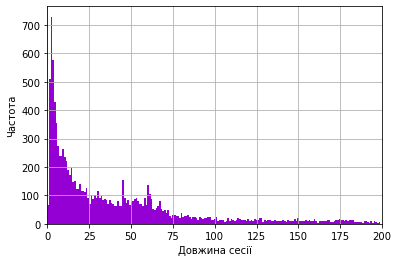

In [17]:
ax = train_data_10users['session_timespan'][train_data_10users['session_timespan'] < 200].hist(color = 'darkviolet', bins = 200)
ax.set_xlabel('Довжина сесії')
ax.set_ylabel('Частота')
ax.set_xlim(left = 0, right = 200)

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0, 0.5, 'Частота')

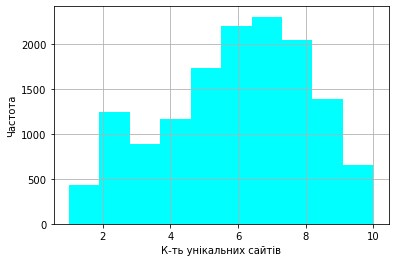

In [18]:
ax = train_data_10users['#unique_sites'].hist(color = 'aqua')
ax.set_xlabel('К-ть унікальних сайтів')
ax.set_ylabel('Частота')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

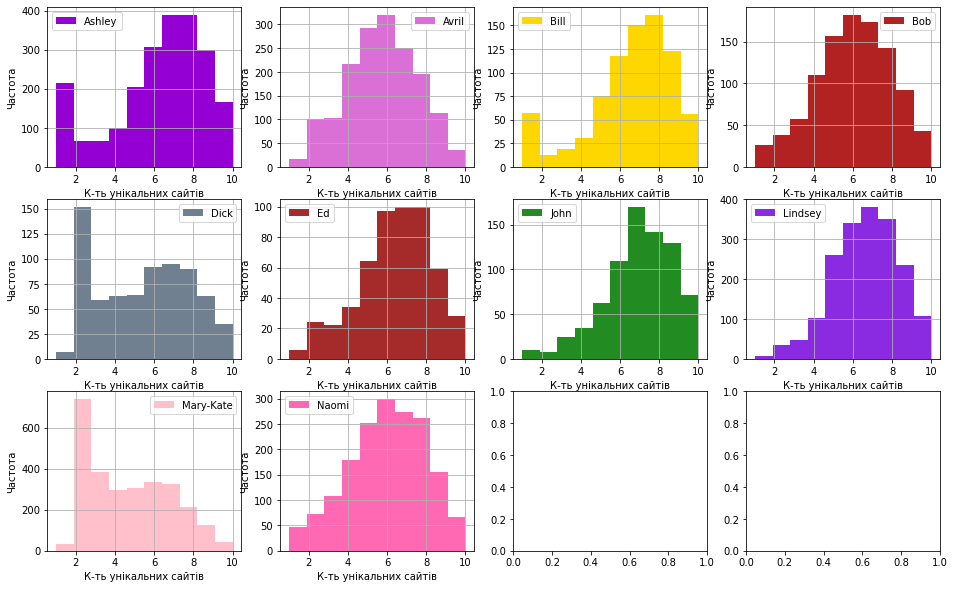

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')):
    ax_idx = np.unravel_index(idx, axes.shape)
    sub_df['#unique_sites'].hist(ax = axes[ax_idx], color = color_dic[user])
    axes[ax_idx].legend((user,))
    axes[ax_idx].set_xlabel('К-ть унікальних сайтів')
    axes[ax_idx].set_ylabel('Частота')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

(0.0, 24.0)

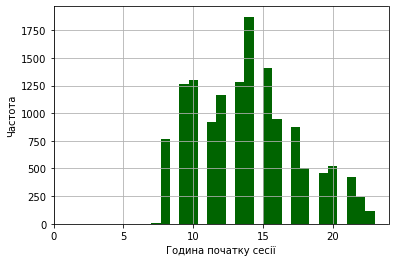

In [20]:
ax = train_data_10users['start_hour'].hist(color = 'darkgreen', bins = 24)
ax.set_xlabel('Година початку сесії')
ax.set_ylabel('Частота')
ax.set_xlim(left = 0, right = 24)

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

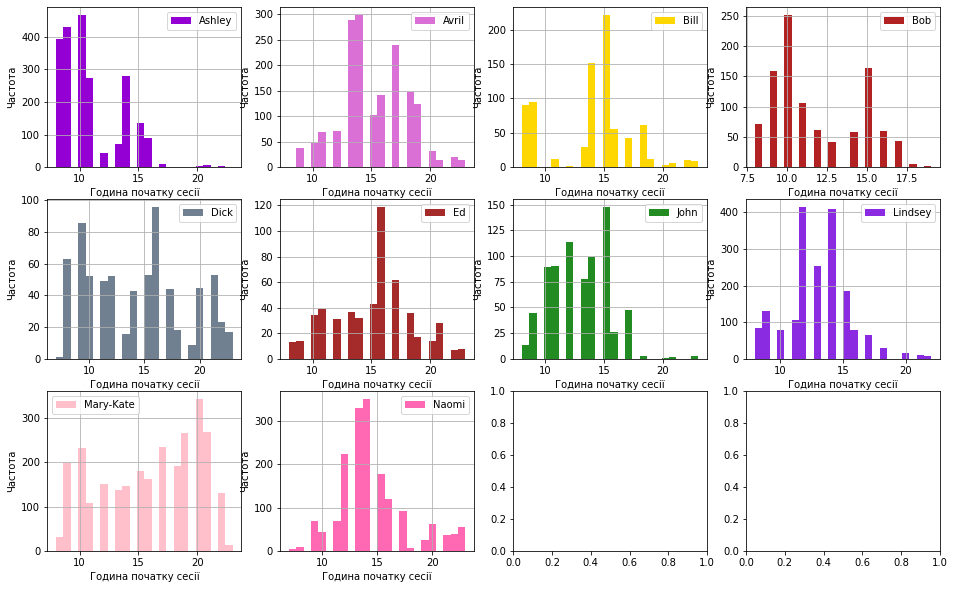

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')):
    ax_idx = np.unravel_index(idx, axes.shape)
    sub_df['start_hour'].hist(ax = axes[ax_idx], color = color_dic[user], bins = 24)
    axes[ax_idx].legend((user,))
    axes[ax_idx].set_xlabel('Година початку сесії')
    axes[ax_idx].set_ylabel('Частота')
    ax.set_xlim(left = 0, right = 24)

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

(0.0, 6.0)

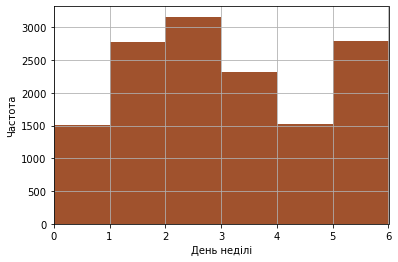

In [22]:
ax = train_data_10users['day_of_week'].hist(color = 'sienna', bins = 6)
ax.set_xlabel('День неділі')
ax.set_ylabel('Частота')
ax.set_xlim(left = 0, right = 6)

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

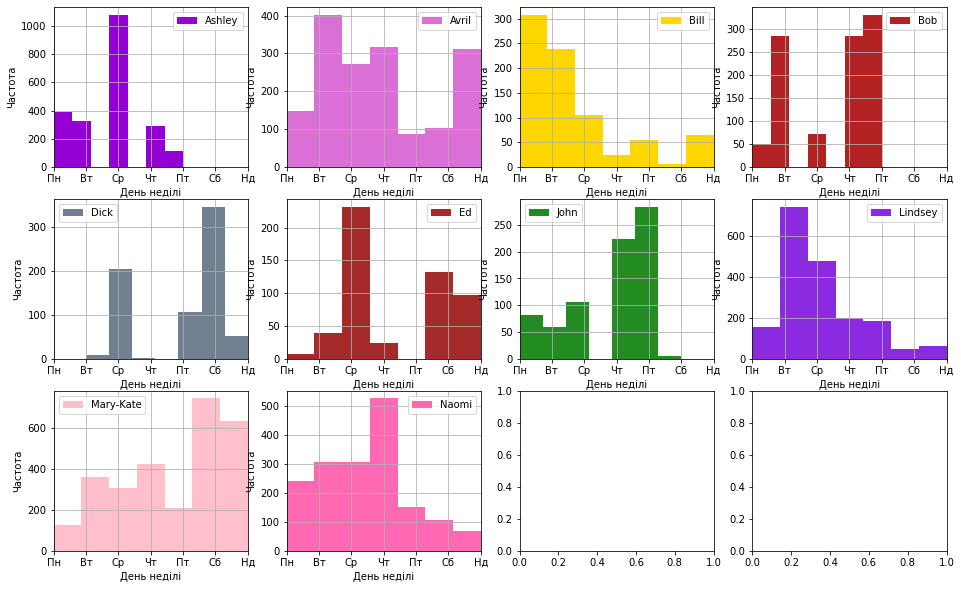

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')):
    ax_idx = np.unravel_index(idx, axes.shape)
    sub_df['day_of_week'].hist(ax = axes[ax_idx], color = color_dic[user], bins = 7)
    axes[ax_idx].legend((user,))
    axes[ax_idx].set_xlabel('День неділі')
    axes[ax_idx].set_ylabel('Частота')
    axes[ax_idx].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Нд'])
    axes[ax_idx].set_xlim(left = 0, right = 6)

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

Ashley - явно виражене найбільше використання інтернету у середу та зранку, що може вказувати на характерний розклад відвідувань та роботи у закладі. Найчастіше, більшість відвідувань сайтів є унікальними у сесії, що може вказувати більше на пошукову/дослідницьку/навчальну діяльність.

Bill - найчастіше використовує інтернет у першій половині неділі. Найбільше інтернет використовує після 15 годин дня.

Mary-Kate - використовує найбільше інтеренет у кінці неділі (вихідні). Використання рівномірно збільшується від першої половини дня до другої. Унікальність сайтів у сесіях вказує на часте відвідування певних ресурсів.

Avril - має відносно рівномірні графіки. Використовує інтернет найбільше до обіду та ближче до вечора (17 год). Майже близький до нормального розподіл унікалних сайтів у сесіях.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [24]:
train_data_10users['target'].unique()

array(['John', 'Bob', 'Ashley', 'Bill', 'Dick', 'Naomi', 'Mary-Kate',
       'Lindsey', 'Avril', 'Ed'], dtype=object)

In [25]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as file:
    site_freq_10users = pickle.load(file)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [26]:
site_freq = pd.DataFrame(index = site_freq_10users.keys(), data = site_freq_10users.values(), columns = ['sites', 'freq'])
site_freq.index, site_freq['sites'] = site_freq['sites'], site_freq.index
site_freq.index.name = 'id'

top10_sites_df = site_freq.nlargest(10, 'freq')
top10_freqs = top10_sites_df['freq']
top10_sites = top10_sites_df['sites']
top10_sites_df

,sites,freq
id,,
69,s.youtube.com,8300
5,www.google.fr,7813
4,www.google.com,5441
7,mail.google.com,4158
8,www.facebook.com,4141
6,apis.google.com,3758
236,r3---sn-gxo5uxg-jqbe.googlevideo.com,3244
593,r1---sn-gxo5uxg-jqbe.googlevideo.com,3094
2,plus.google.com,2630


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

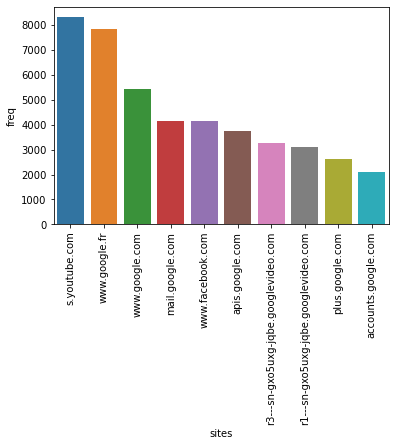

In [27]:
ax = sns.barplot(x = top10_sites, y = top10_freqs)
ax = ax.set_xticklabels(top10_sites, rotation = 90)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [69]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):


    files_list = glob(os.path.join(path_to_csv_files, 'user*.csv'))

    sites = list()
    diffs = list()
    session_timespan = list()
    unique_sites = list()
    start_hour = list()
    day_of_week = list()
    y_users = list()

    #new features:
    mean_timespan = list()
    median_timespan = list()
    usites_to_timespan = list()

    with open(site_freq_path, 'rb') as file:
            sites_dict = pickle.load(file)


    for path in tqdm_notebook(files_list):

            # зчитування
            df = pd.read_csv(path)

            # обробка сайтів та заміна значень зі словника
            df['site'] = df['site'].apply(lambda i: sites_dict[i][0])
            df = df.to_numpy()


            # створення координат для нової матриці за введеними параметрами session_length та window_size
            coords = np.array([np.arange(i, i + session_length) for i in range(0, df.shape[0], window_size)])

            # додавання нулів
            zeroes = [0] * (coords.size - df.shape[0])
            zeroes = np.array(zeroes * 2).reshape((len(zeroes), 2))
            if zeroes.shape[0] > 0:
                df = np.concatenate((df, zeroes), axis = 0)

            # створення матриці за координатами
            diffs.append(np.apply_along_axis(np.vectorize(lambda i: df[i, 0]), 1, coords))
            sites.append(np.apply_along_axis(np.vectorize(lambda i: df[i, 1]), 1, coords))

            # додаємо до вектора годин та дня неділі сесії значення
            min_time_values = pd.to_datetime(diffs[-1][:, 0])
            start_hour += list(min_time_values.hour)
            day_of_week += list(min_time_values.dayofweek)

            # обробка часу
            t1 = diffs[-1][:, 1:].astype(np.datetime64)
            t2 = diffs[-1][:, :-1].astype(np.datetime64)
            diffs[-1] = (t1 - t2).astype(np.int64)
            diffs[-1][diffs[-1] < 0] = 0


            # додаємо до вектора часу сесії значення
            session_timespan += list(np.apply_along_axis(np.sum, 1, diffs[-1]))

            # додаємо до вектора часу сесії значення
            unique_sites += list(np.apply_along_axis(lambda i: np.unique(i[i != 0]).size, 1, sites[-1]))

            # додаємо до вектора відповідей ID користувачів
            y_users += [int(os.path.basename(path)[4:8])] * sites[-1].shape[0]

            # додавання нових фіч:
            mean_timespan += list(np.apply_along_axis(np.mean, 1, diffs[-1]))
            median_timespan += list(np.apply_along_axis(np.median, 1, diffs[-1]))


    # об'єднання
    sites = np.concatenate(sites, axis = 0)
    diffs = np.concatenate(diffs, axis = 0)
    
    # нові фічі
    usites_to_timespan = np.array(session_timespan) / np.array(unique_sites)

    matr = np.concatenate((sites, 
                           diffs,
                           np.array(session_timespan).reshape(-1, 1),
                           np.array(unique_sites).reshape(-1, 1),
                           np.array(start_hour).reshape(-1, 1),
                           np.array(day_of_week).reshape(-1, 1),
                           np.array(mean_timespan).reshape(-1, 1),
                           np.array(median_timespan).reshape(-1, 1),
                           np.array(usites_to_timespan).reshape(-1, 1),
                           np.array(y_users).reshape(-1, 1)),
                          axis = 1)

    return pd.DataFrame(matr, columns = feature_names)

In [29]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'mean_timespan', 'median_timespan', 'usites_to_timespan', 'target']

In [61]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                           feature_names=feature_names, 
                                           session_length=10)


Wall time: 5.6 s


In [53]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                           feature_names=feature_names, 
                                           session_length=10)


Wall time: 45.8 s


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

1.000000      245
0.500000      225
0.111111      207
0.333333      197
0.250000      186
             ... 
744.500000      1
68.625000       1
923.000000      1
423.000000      1
110.777778      1
Name: usites_to_timespan, Length: 3023, dtype: int64

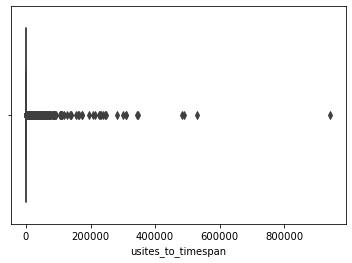

In [32]:
sns.boxplot(new_features_10users['usites_to_timespan'])
new_features_10users['usites_to_timespan'].value_counts()

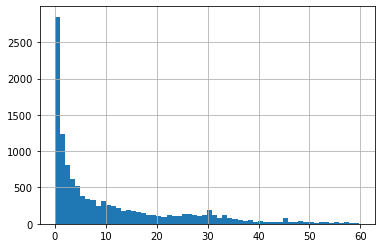

In [33]:
new_features_10users['usites_to_timespan'][new_features_10users['usites_to_timespan'] < 60].hist(bins = 60)

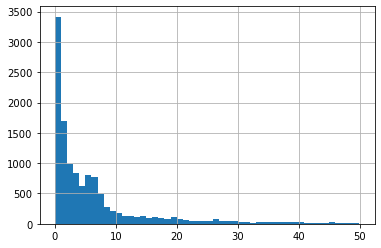

In [34]:
new_features_10users['mean_timespan'][new_features_10users['mean_timespan']<50].hist(bins = 50)

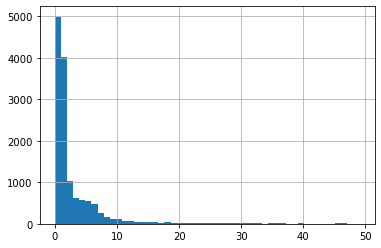

In [35]:
new_features_10users['median_timespan'][new_features_10users['median_timespan']<50].hist(bins = 50)

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [36]:
selected_features_10users = new_features_10users[['mean_timespan', 'median_timespan', 'usites_to_timespan']]
selected_features_150users = new_features_150users[['mean_timespan', 'median_timespan', 'usites_to_timespan']] 

In [37]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

In [70]:
%%time
# збереження додаткового файла
fe_df = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                           feature_names=feature_names, 
                                           session_length= 10,
                                           window_size = 10)

with open(os.path.join(PATH_TO_DATA, 'df_new_features_150users.pkl'), 'wb') as file:
    pickle.dump(fe_df, file, protocol = 2)


Wall time: 46 s


### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 